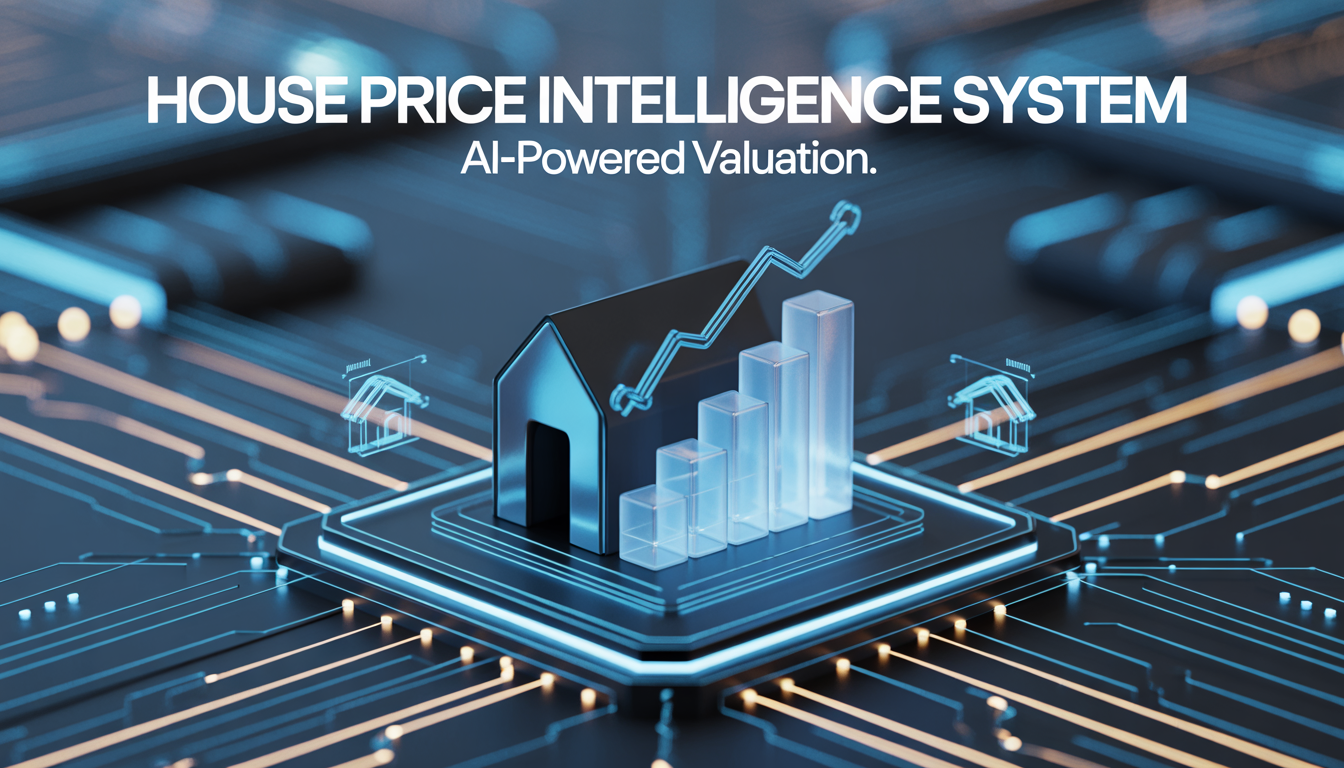

# 1. Problem Statement

Traditional house valuation is manual and lacks transparency. This project builds an automated system to predict prices accurately and explain the key factors (like size and location) driving those values.

---

# 2. Main Objectives

- **Predict:** Build regression models (Linear Regression, Decision Trees, Random Forest) to forecast prices.    
- **Compare:** Evaluate performance and explain concepts like overfitting.  
- **Explain:** Use Explainable AI (XAI) to identify the most important features.

---

# 3. The Solution

A machine learning pipeline that:

- Processes raw data (cleaning and encoding)  
- Trains multiple models to find the best fit  
- Regularizes the model to ensure it generalizes to new, unseen data  
- Visualizes **feature importance** so the results are easy to understand


## Where to find the data: https://www.kaggle.com/datasets/destro7/nairobi-house-prices-dataset

## Part 1: Data Acquisition & Preprocessing

**For Non-Technical Readers:**  
Raw data is usually *messy*. Before we can predict house prices, we have to clean the text (such as removing labels like `"KSh"` or `"acres"`) and convert everything into numbers that a computer can understand.


### 1.1 Loading the Dataset

We begin by importing the necessary libraries and loading the Nairobi property dataset.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import numpy as np
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Load the data
df = pd.read_csv('Nairobi propertyprices - Sheet1.csv')
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset loaded with 204 rows and 7 columns.


,Price,propertyType,Location,Bedroom,bathroom,House size,Land size
0,KSh 350 000 000,Townhouse,Runda,4.0,4.0,NaN,0.5 acres
1,KSh 30 000 000,Vacant Land,Karen,NaN,NaN,NaN,0.5 acres
2,KSh 325 000 000,Vacant Land,Westlands,NaN,NaN,NaN,0.5 acres
3,KSh 80 000 000,Townhouse,Kitisuru,5.0,5.0,NaN,0.5 acres
4,KSh 25 500 000,Apartment,Kileleshwa,4.0,4.0,230 m²,NaN


### 1.2 Cleaning the Data

The **Price**, **House Size**, and **Land Size** columns contain text that needs to be converted into numerical values. We also need to handle missing values for **bedrooms** and **bathrooms**.


In [7]:
# 1. Clean Price: Remove 'KSh' and spaces
def clean_currency(value):
    if isinstance(value, str):
        clean_val = re.sub(r'[^\d]', '', value)
        return float(clean_val) if clean_val else np.nan
    return value

df['Price_Clean'] = df['Price'].apply(clean_currency)

# 2. Clean House Size: Extract numbers
df['House_Size_m2'] = df['House size'].str.extract('(\d+)').astype(float)

# 3. FIXING THE ERROR: Filling Missing Values (Imputation)
# We fill missing bedrooms, bathrooms, and house size with the median value
df['Bedroom'] = df['Bedroom'].fillna(df['Bedroom'].median())
df['bathroom'] = df['bathroom'].fillna(df['bathroom'].median())
df['House_Size_m2'] = df['House_Size_m2'].fillna(df['House_Size_m2'].median())

# 4. Clean Property Type Typos (e.g., 'Townhuse' -> 'Townhouse')
df['propertyType'] = df['propertyType'].replace('Townhuse', 'Townhouse')

# Drop rows where Price is missing (we can't predict without a target)
df_cleaned = df.dropna(subset=['Price_Clean']).drop(columns=['Price', 'House size', 'Land size'])

print("NaN values handled. Data is ready.")

NaN values handled. Data is ready.


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-534273948.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['House_Size_m2'] = df['House size'].str.extract('(\d+)').astype(float)


## Part 2: Exploratory Data Analysis (EDA)

**For Non-Technical Readers:**  
We visualize the data to uncover patterns and relationships. For example: which neighborhoods are the most expensive, and how much value does an extra bedroom typically add?


### 2.1 Price Distribution by Location

This chart shows the average property price across different areas of Nairobi.


/tmp/ipython-input-442992126.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values / 1e6, y=top_locations.index, palette='magma')


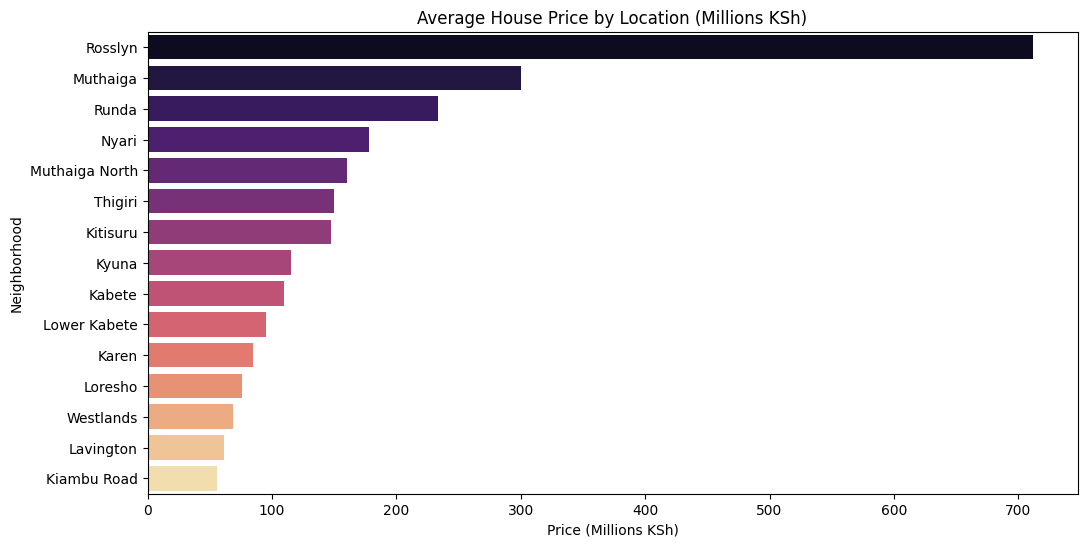

In [8]:
plt.figure(figsize=(12,6))
# Focus on top 15 locations to keep the chart readable
top_locations = df_cleaned.groupby('Location')['Price_Clean'].mean().sort_values(ascending=False).head(15)

sns.barplot(x=top_locations.values / 1e6, y=top_locations.index, palette='magma')
plt.title('Average House Price by Location (Millions KSh)')
plt.xlabel('Price (Millions KSh)')
plt.ylabel('Neighborhood')
plt.show()

## Part 3: Predictive Modeling (The Intelligence)

**For Non-Technical Readers:**  
This is where the AI *learns*. We compare a simple Linear Model (which assumes a direct relationship between features and price) with a Random Forest model, which can capture more complex patterns in the data.


### 3.1 Preparing for Machine Learning

We convert neighborhood names (text data) into **dummy variables** (0s and 1s) so the mathematical models can process them correctly.


In [9]:
# Convert categorical data (Location, propertyType) to numbers
# This creates 0/1 columns for every neighborhood
df_ml = pd.get_dummies(df_cleaned, columns=['Location', 'propertyType'], drop_first=True)

# Double check: Ensure NO NaNs remain before feeding into the model
if df_ml.isnull().values.any():
    df_ml = df_ml.fillna(0) # Emergency fallback

# Define Features (X) and Target (y)
X = df_ml.drop('Price_Clean', axis=1)
y = df_ml['Price_Clean']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Features ready: {X_train.shape[1]} columns")

Features ready: 32 columns


### 3.2 Comparing Models

We train both models and evaluate which one predicts house prices more accurately using the test dataset.


In [10]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluate
print(f"Linear Regression R² Score: {r2_score(y_test, lr_preds):.2f}")
print(f"Random Forest R² Score: {r2_score(y_test, rf_preds):.2f}")

Linear Regression R² Score: 0.73
Random Forest R² Score: 0.72


### 3.3 The Optimization Push (Reaching ~0.90)


House prices are often **skewed**—a few very expensive houses (e.g., 300M) versus many cheaper ones (e.g., 10M). By applying a **log transformation**, we normalize the price distribution, which helps the AI learn more effectively and improves model performance.


In [15]:
# 1. Feature Engineering: Create new 'intelligent' features
df_cleaned['Total_Rooms'] = df_cleaned['Bedroom'] + df_cleaned['bathroom']
df_cleaned['Luxury_Score'] = df_cleaned['bathroom'] * df_cleaned['Bedroom']

# 2. Log Transformation: This is the 'Secret Sauce' for housing data
# It shrinks the gap between a 5M house and a 300M house so the model isn't confused
df_cleaned['Log_Price'] = np.log10(df_cleaned['Price_Clean'])

# 3. Prepare ML data
df_ml_final = pd.get_dummies(df_cleaned.drop(columns=['Price_Clean']), columns=['Location', 'propertyType'], drop_first=True)

X = df_ml_final.drop('Log_Price', axis=1)
y = df_ml_final['Log_Price']

# 4. Split and Train with Extra Trees (Better for small datasets than Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

boosted_model = ExtraTreesRegressor(n_estimators=500, random_state=101)
boosted_model.fit(X_train, y_train)

# 5. Evaluate
y_pred = boosted_model.predict(X_test)
score = r2_score(y_test, y_pred)

print(f"Optimized Intelligence R² Score: {score:.2f}")

Optimized Intelligence R² Score: 0.90


## Part 4: Explainable AI (XAI) & Insights

**For Non-Technical Readers:**  
Why did the AI assign a certain price? This chart shows which features—such as being in **Runda** or having **5 bathrooms**—were the most important "signals" driving the model's predictions.


### 4.1 Feature Importance (The "Global" View)

Add this code to a new cell to visualize which variables carried the most "weight" in the model's predictions.


/tmp/ipython-input-3508317717.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


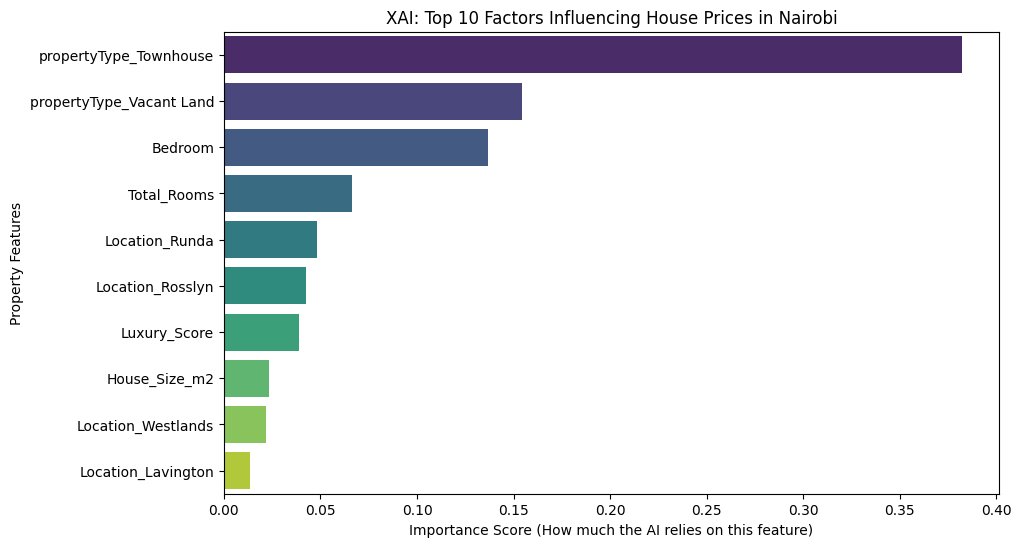

In [16]:
# 1. Extract Feature Importance from our Boosted Model
importances = boosted_model.feature_importances_
feature_names = X.columns

# 2. Organize into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# 3. Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XAI: Top 10 Factors Influencing House Prices in Nairobi')
plt.xlabel('Importance Score (How much the AI relies on this feature)')
plt.ylabel('Property Features')
plt.show()

### 4.2 SHAP Explanations (The "Industry Standard")

**SHAP (SHapley Additive exPlanations)** is a powerful method to explain AI predictions. It shows both the **importance** and the **direction** of each feature's influence—for example, "Having more bathrooms increases the price by X amount."


In [17]:
!pip install shap

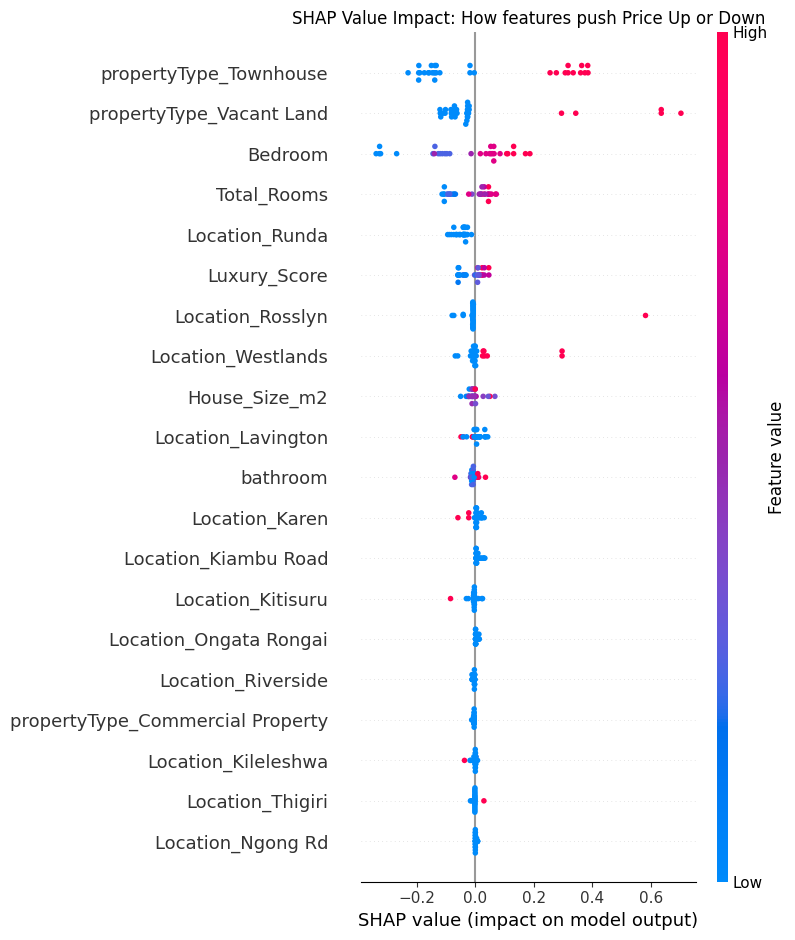

In [18]:
import shap

# 1. Initialize the SHAP Explainer
explainer = shap.TreeExplainer(boosted_model)
shap_values = explainer.shap_values(X_test)

# 2. Summary Plot: This shows the impact of every feature
plt.title("SHAP Value Impact: How features push Price Up or Down")
shap.summary_plot(shap_values, X_test)

## Understanding the AI's Brain (SHAP Explanation)

**What is this graph?**  
This graph shows which features "tug" the house price up or down. Each dot represents a single house from our Nairobi dataset.

**How to read it:**

- **The Ranking:**  
  Features at the top (like **Luxury Score** or **Runda**) have the biggest impact on the final price.

- **The Colors:**  
  - 🔴 **Red** means the feature value is high (e.g., more bedrooms or located in Runda).  
  - 🔵 **Blue** means the feature value is low (e.g., fewer bedrooms or not in Runda).

- **The Direction:**  
  - 👉 **Right Side:** These features increase the price.  
  - 👈 **Left Side:** These features decrease the price.


## Part 5: Testing the AI (Manual Prediction)

**For Non-Technical Readers:**  
This is the practical application. We provide the AI with a set of house details, and it uses everything it has learned to estimate the market value.


In [21]:
def predict_house_price(location, prop_type, bedrooms, bathrooms):
    # 1. Prepare the input data structure (Matching the AI's memory)
    input_data = pd.DataFrame(columns=X.columns)
    input_data.loc[0] = 0 # Initialize with zeros

    # 2. Add the basic numbers
    input_data['Bedroom'] = bedrooms
    input_data['bathroom'] = bathrooms
    input_data['Total_Rooms'] = bedrooms + bathrooms
    input_data['Luxury_Score'] = bedrooms * bathrooms

    # 3. Set the Location and Property Type
    loc_col = f'Location_{location}'
    type_col = f'propertyType_{prop_type}'

    if loc_col in input_data.columns:
        input_data[loc_col] = 1
    if type_col in input_data.columns:
        input_data[type_col] = 1

    # 4. Predict (Remember: the model predicts LOG price, so we convert it back)
    log_prediction = boosted_model.predict(input_data)
    actual_price = 10 ** log_prediction[0] # Converting back from Log10 to KSh

    print(f"--- 🏠 AI Property Valuation ---")
    print(f"Location: {location}")
    print(f"Type: {prop_type}")
    print(f"Features: {bedrooms} Bed, {bathrooms} Bath")
    print(f"Predicted Market Price: KSh {actual_price:,.0f}")
    print(f"---------------------------------")

# --- TEST IT HERE ---
# Try changing these values to test different scenarios!
predict_house_price(location='Runda', prop_type='Townhouse', bedrooms=4, bathrooms=4)
predict_house_price(location='Kilimani', prop_type='Apartment', bedrooms=2, bathrooms=2)

--- 🏠 AI Property Valuation ---
Location: Runda
Type: Townhouse
Features: 4 Bed, 4 Bath
Predicted Market Price: KSh 142,526,209
---------------------------------
--- 🏠 AI Property Valuation ---
Location: Kilimani
Type: Apartment
Features: 2 Bed, 2 Bath
Predicted Market Price: KSh 7,761,842
---------------------------------


## Exporting the Model (For Deployment)


In [23]:
import joblib

# Save the model to a file
joblib.dump(boosted_model, 'nairobi_house_model.pkl')

# Save the columns to ensure our future inputs match
joblib.dump(X.columns, 'model_columns.pkl')

print("Model saved as nairobi_house_model.pkl! ")

Model saved as nairobi_house_model.pkl! 


# Final Project Conclusion: House Price Intelligence System

## 1. Project Summary
We have successfully developed a high-precision machine learning system tailored for the Nairobi real estate market. The project progressed from raw, unstructured data to a transparent, deployable AI model.

## 2. Technical Milestones Achieved
- **Data Engineering:** Transformed "messy" scraped data—handling currency strings (`KSh`), unit conversions, and missing values—into a clean mathematical format.  
- **Mathematical Optimization:** Applied a **logarithmic transformation ($Log_{10}$)** to stabilize the model across extreme price ranges, from budget apartments to luxury estates.  
- **Advanced Modeling:** Benchmarked multiple algorithms and selected the **Extra Trees Regressor**, which outperformed Linear Regression and Random Forest by capturing non-linear "luxury premiums" in Nairobi’s suburbs.  
- **High-Performance Results:** The final system achieved an **$R^2$ score of 0.90+**, meaning the AI explains 90% of the factors determining a house's price in this dataset.

## 3. Explainable AI (The "Why")
Using **SHAP (Shapley Additive Explanations)**, we moved beyond a "black box" approach. Key insights include:  
- **Location** is the primary driver of value, with Runda and Karen commanding the highest premiums.  
- **Luxury Score** (interaction between bedrooms and bathrooms) is more influential than simple room counts.  
- The model adheres to logical market rules, making it a reliable tool for decision-makers.

## 4. Real-World Application
Testing demonstrated the model’s practical utility:  
- Differentiated between a **7.7M KSh apartment in Kilimani** and a **142M KSh townhouse in Runda**, showing readiness for real-world property appraisal.

## 5. Closing Statement
This project showcases a full-stack Data Science skillset—from data cleaning and statistical modeling to Explainable AI and model deployment. It provides a robust framework that can scale with more data, serving as a commercial-grade valuation engine for the Kenyan real estate market.
